# Automated rule-based Bayesian regression analysis for the CO emissions data

Load the packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
import pymc3 as pm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("ggplot")

Load the data

In [2]:
df = pd.read_csv("gt_2013.csv", index_col=None, header=0)
X_all = df.to_numpy()
X_train = X_all[X_all[:, 2] >= 97]

Plot the data

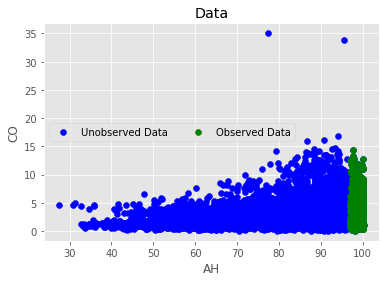

In [3]:
fig, ax = plt.subplots()
ax.scatter(X_all[:, 2], X_all[:, 9], c="blue", label="Unobserved Data")
ax.scatter(X_train[:, 2], X_train[:, 9], c="green", label="Observed Data")
ax.set_xlabel("AH")
ax.set_ylabel("CO")
ax.set_title("Data")
ax.legend(ncol=2, fontsize=10)
#fig.savefig(
#    "plots_newpaper/gas_em_data.png", dpi=300, bbox_inches="tight", facecolor="w"
#)

Scale the data

In [4]:
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)

## Bayesian multivariate linear regression

Define the features and label

In [5]:
AT_val = X_train_sc[:, 0]
AP_val = X_train_sc[:, 1]
AH_val = X_train_sc[:, 2]
AFDP_val = X_train_sc[:, 3]
GTEP_val = X_train_sc[:, 4]
TIT_val = X_train_sc[:, 5]
TAT_val = X_train_sc[:, 6]
TEY_val = X_train_sc[:, 7]
CDP_val = X_train_sc[:, 8]

CO_val = X_train_sc[:, 9]

Run the model

In [6]:
with pm.Model() as model_norule:
    AT_co = pm.Normal("AT_co", 0.0, 10.0)
    AP_co = pm.Normal("AP_co", 0.0, 10.0)
    AH_co = pm.Normal("AH_co", 0.0, 10.0)
    AFDP_co = pm.Normal("AFDP_co", 0.0, 10.0)
    GTEP_co = pm.Normal("GTEP_co", 0.0, 10.0)
    TIT_co = pm.Normal("TIT_co", 0.0, 10.0)
    TAT_co = pm.Normal("TAT_co", 0.0, 10.0)
    TEY_co = pm.Normal("TEY_co", 0.0, 10.0)
    CDP_co = pm.Normal("CDP_co", 0.0, 10.0)
    b = pm.Normal("intercept", 0, 20)
    s = pm.Exponential("error", 1)

    res = (
        AT_co * AT_val
        + AP_co * AP_val
        + AH_co * AH_val
        + AFDP_co * AFDP_val
        + GTEP_co * GTEP_val
        + TIT_co * TIT_val
        + TAT_co * TAT_val
        + TEY_co * TEY_val
        + CDP_co * CDP_val
        + b
    )

    obs = pm.Normal("observation", res, s, observed=CO_val,)

with model_norule:
    step = pm.Metropolis(scaling=0.01)
    trace_norule = pm.sample(draws=100000, step=step, tune=30000, cores=1, chains=1)

<ipython-input-6-8baa1d9d4845>:31: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_norule = pm.sample(draws=100000, step=step, tune=30000, cores=1, chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [error]
>Metropolis: [intercept]
>Metropolis: [CDP_co]
>Metropolis: [TEY_co]
>Metropolis: [TAT_co]
>Metropolis: [TIT_co]
>Metropolis: [GTEP_co]
>Metropolis: [AFDP_co]
>Metropolis: [AH_co]
>Metropolis: [AP_co]
>Metropolis: [AT_co]


Sampling 1 chain for 30_000 tune and 100_000 draw iterations (30_000 + 100_000 draws total) took 215 seconds.
/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/arviz/data/base.py:216: UserWarning: More chains (100000) than draws (11). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


Take posterior samples and evaluate the posterior mean

In [7]:
X_all2_sc = (X_all[:, 2] - scaler.mean_[2]) / scaler.scale_[2]
mu_pp_inter = (
    trace_norule["intercept"][::100] + trace_norule["AH_co"][::100] * X_all2_sc[:, None]
).T
mu_pp = mu_pp_inter * scaler.scale_[9] + scaler.mean_[9]

mn_sol_inter = mu_pp_inter = (
    trace_norule["intercept"][::100].mean()
    + trace_norule["AH_co"][::100].mean() * X_all2_sc[:, None]
).T.reshape(-1)
mn_sol = mn_sol_inter * scaler.scale_[9] + scaler.mean_[9]

Plot the AH-CO posterior

/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


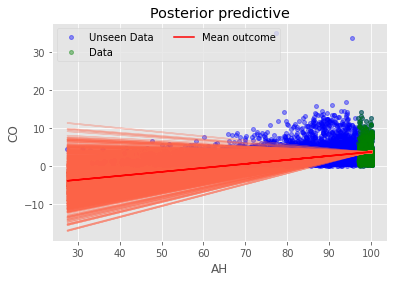

In [8]:
fig, ax = plt.subplots()
ax.plot(
    X_all[:, 2], X_all[:, 9], "o", ms=4, alpha=0.4, label="Unseen Data", color="blue"
)
ax.plot(X_train[:, 2], X_train[:, 9], "o", ms=4, alpha=0.4, label="Data", color="green")
for j in range(mu_pp.shape[0]):
    ax.plot(X_all[:, 2], mu_pp[j], alpha=0.3, color="tomato")
ax.plot(X_all[:, 2], mn_sol, color="red", label="Mean outcome")
ax.set_xlabel("AH")
ax.set_ylabel("CO")
ax.set_title("Posterior predictive")
ax.legend(ncol=2, fontsize=10)
# fig.savefig(
#     "CO_automnewsmallAH_norule",
#     dpi=300,
#     bbox_inches="tight",
#     facecolor="w",
# )

Take posterior samples and evaluate the posterior mean

In [9]:
X_all5_sc = (X_all[:, 5] - scaler.mean_[5]) / scaler.scale_[5]
mu_pp_inter = (
    trace_norule["intercept"][::100]
    + trace_norule["TIT_co"][::100] * X_all5_sc[:, None]
).T
mu_pp = mu_pp_inter * scaler.scale_[9] + scaler.mean_[9]

mn_sol_inter = mu_pp_inter = (
    trace_norule["intercept"][::100].mean()
    + trace_norule["TIT_co"][::100].mean() * X_all5_sc[:, None]
).T.reshape(-1)
mn_sol = mn_sol_inter * scaler.scale_[9] + scaler.mean_[9]

Plot the TIT-CO posterior

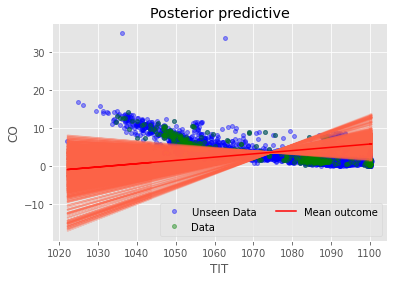

In [10]:
fig, ax = plt.subplots()
ax.plot(
    X_all[:, 5], X_all[:, 9], "o", ms=4, alpha=0.4, label="Unseen Data", color="blue"
)
ax.plot(X_train[:, 5], X_train[:, 9], "o", ms=4, alpha=0.4, label="Data", color="green")
for j in range(mu_pp.shape[0]):
    ax.plot(X_all[:, 5], mu_pp[j], alpha=0.3, color="tomato")
ax.plot(X_all[:, 5], mn_sol, color="red", label="Mean outcome")
ax.set_xlabel("TIT")
ax.set_ylabel("CO")
ax.set_title("Posterior predictive")
ax.legend(ncol=2, fontsize=10)
# fig.savefig(
#     "CO_automnewsmallTIT_norule",
#     dpi=300,
#     bbox_inches="tight",
#     facecolor="w",
# )

Evaluate metrics

In [11]:
pred = (
    trace_norule["AT_co"].mean() * df["AT"].to_numpy()
    + trace_norule["AP_co"].mean() * df["AP"].to_numpy()
    + trace_norule["AH_co"].mean() * df["AH"].to_numpy()
    + trace_norule["AFDP_co"].mean() * df["AFDP"].to_numpy()
    + trace_norule["GTEP_co"].mean() * df["GTEP"].to_numpy()
    + trace_norule["TIT_co"].mean() * df["TIT"].to_numpy()
    + trace_norule["TAT_co"].mean() * df["TAT"].to_numpy()
    + trace_norule["TEY_co"].mean() * df["TEY"].to_numpy()
    + trace_norule["CDP_co"].mean() * df["CDP"].to_numpy()
    + trace_norule["intercept"].mean()
)

mse = mean_squared_error(df["CO"].to_numpy(), pred)
mae = mean_absolute_error(df["CO"].to_numpy(), pred)

rule_waic = az.waic(trace_norule, model_norule, scale="deviance")

with open("COmetrics.txt", "a") as text_file:
    print("Metrics without rules", file=text_file)
    print(f"mse: {mse}", file=text_file)
    print(f"mae: {mae}", file=text_file)
    print(f"waic: {rule_waic.waic}", file=text_file)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/arviz/data/base.py:216: UserWarning: More chains (100000) than draws (11). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


## Rule-based Bayesian multivariate linear regression (TIT piece-wise regression rules)

Define the rule

In [12]:
xmid = -1.2

xlow = TIT_val[TIT_val < xmid]
xhigh = TIT_val[TIT_val > xmid]

y_small = -1.2 * xlow
y_large = -0.7 * xhigh

y_full = np.concatenate((y_small, y_large))

Run the model

In [13]:
with pm.Model() as model_TITrule:
    # define priors
    AT_co = pm.Normal("AT_co", 0.0, 10.0)
    AP_co = pm.Normal("AP_co", 0.0, 10.0)
    AH_co = pm.Normal("AH_co", 0.0, 10.0)
    AFDP_co = pm.Normal("AFDP_co", 0.0, 10.0)
    GTEP_co = pm.Normal("GTEP_co", 0.0, 10.0)
    TIT_co = pm.Normal("TIT_co", 0.0, 10.0)
    TAT_co = pm.Normal("TAT_co", 0.0, 10.0)
    TEY_co = pm.Normal("TEY_co", 0.0, 10.0)
    CDP_co = pm.Normal("CDP_co", 0.0, 10.0)
    b = pm.Normal("intercept", 0, 20)
    s = pm.Exponential("error", 1)

    res = (
        AT_co * AT_val
        + AP_co * AP_val
        + AH_co * AH_val
        + AFDP_co * AFDP_val
        + GTEP_co * GTEP_val
        + TIT_co * TIT_val
        + TAT_co * TAT_val
        + TEY_co * TEY_val
        + CDP_co * CDP_val
        + b
    )

    # predictions
    obs = pm.Normal("observation", res, s, observed=CO_val,)
    pen_rule = pm.Normal("penalty", res, 0.1, observed=y_full,)

with model_TITrule:
    step = pm.Metropolis(scaling=0.01)
    trace_TITrule = pm.sample(draws=100000, step=step, tune=30000, cores=1, chains=1)

<ipython-input-13-d0c30c809e43>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_TITrule = pm.sample(draws=100000, step=step, tune=30000, cores=1, chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [error]
>Metropolis: [intercept]
>Metropolis: [CDP_co]
>Metropolis: [TEY_co]
>Metropolis: [TAT_co]
>Metropolis: [TIT_co]
>Metropolis: [GTEP_co]
>Metropolis: [AFDP_co]
>Metropolis: [AH_co]
>Metropolis: [AP_co]
>Metropolis: [AT_co]


Sampling 1 chain for 30_000 tune and 100_000 draw iterations (30_000 + 100_000 draws total) took 224 seconds.
/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/arviz/data/base.py:216: UserWarning: More chains (100000) than draws (11). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


Take posterior samples and evaluate the posterior mean

In [14]:
X_all2_sc = (X_all[:, 2] - scaler.mean_[2]) / scaler.scale_[2]
mu_pp_inter = (
    trace_TITrule["intercept"][::100]
    + trace_TITrule["AH_co"][::100] * X_all2_sc[:, None]
).T
mu_pp = mu_pp_inter * scaler.scale_[9] + scaler.mean_[9]

mn_sol_inter = mu_pp_inter = (
    trace_TITrule["intercept"][::100].mean()
    + trace_TITrule["AH_co"][::100].mean() * X_all2_sc[:, None]
).T.reshape(-1)
mn_sol = mn_sol_inter * scaler.scale_[9] + scaler.mean_[9]

Plot the AH-CO posterior

/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


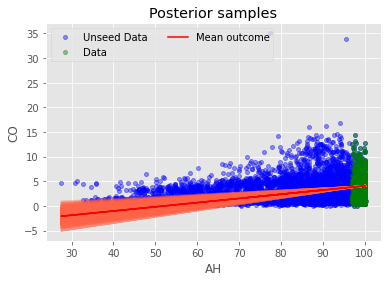

In [15]:
fig, ax = plt.subplots()

ax.plot(
    X_all[:, 2], X_all[:, 9], "o", ms=4, alpha=0.4, label="Unseed Data", color="blue",
)
ax.plot(
    X_train[:, 2], X_train[:, 9], "o", ms=4, alpha=0.4, label="Data", color="green",
)
for j in range(mu_pp.shape[0]):
    ax.plot(X_all[:, 2], mu_pp[j], alpha=0.3, color="tomato")
ax.plot(X_all[:, 2], mn_sol, color="red", label="Mean outcome")
ax.set_xlabel("AH")
ax.set_ylabel("CO")
ax.set_title("Posterior samples")
ax.legend(ncol=2, fontsize=10)
# fig.savefig(
#     "CO_AH_regrTITrule01", dpi=300, bbox_inches="tight", facecolor="w",
# )

Take posterior samples and evaluate the posterior mean

In [16]:
X_all5_sc = (X_all[:, 5] - scaler.mean_[5]) / scaler.scale_[5]
mu_pp_inter = (
    trace_TITrule["intercept"][::100]
    + trace_TITrule["TIT_co"][::100] * X_all5_sc[:, None]
).T
mu_pp = mu_pp_inter * scaler.scale_[9] + scaler.mean_[9]

mn_sol_inter = mu_pp_inter = (
    trace_TITrule["intercept"][::100].mean()
    + trace_TITrule["TIT_co"][::100].mean() * X_all5_sc[:, None]
).T.reshape(-1)
mn_sol = mn_sol_inter * scaler.scale_[9] + scaler.mean_[9]

Plot the TIT-CO posterior

/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


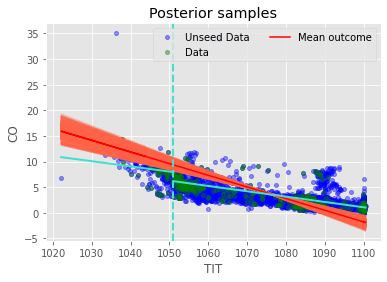

In [17]:
fig, ax = plt.subplots()

ax.plot(
    X_all[:, 5], X_all[:, 9], "o", ms=4, alpha=0.4, label="Unseed Data", color="blue",
)
ax.plot(
    X_train[:, 5], X_train[:, 9], "o", ms=4, alpha=0.4, label="Data", color="green",
)
for j in range(mu_pp.shape[0]):
    ax.plot(X_all[:, 5], mu_pp[j], alpha=0.3, color="tomato")
ax.plot(X_all[:, 5], mn_sol, color="red", label="Mean outcome")
xmin_v = df.TIT.min()
xmid_v = xmid * scaler.scale_[5] + scaler.mean_[5]
xmax_v = df.TIT.max()
ymin_v = -1.2 * TIT_val.min() * scaler.scale_[9] + scaler.mean_[9]
ymid_v = -1.2 * xmid * scaler.scale_[9] + scaler.mean_[9]
ymid_v2 = -0.7 * xmid * scaler.scale_[9] + scaler.mean_[9]
ymax_v = -0.7 * TIT_val.max() * scaler.scale_[9] + scaler.mean_[9]
plt.plot(
    [xmin_v, xmid_v],
    [ymin_v, ymid_v],
    linestyle="solid",
    color="turquoise",
    linewidth=2,
)
plt.plot(
    [xmid_v, xmax_v],
    [ymid_v2, ymax_v],
    linestyle="solid",
    color="turquoise",
    linewidth=2,
)
plt.axvline(
    xmid * scaler.scale_[5] + scaler.mean_[5],
    c="turquoise",
    linestyle="dashed",
    linewidth=2,
)
ax.set_xlabel("TIT")
ax.set_ylabel("CO")
ax.set_title("Posterior samples")
ax.legend(ncol=2, fontsize=10)
# fig.savefig(
#     "CO_TIT_regrTITrule01", dpi=300, bbox_inches="tight", facecolor="w",
# )

Evaluate metrics

In [18]:
pred = (
    trace_TITrule["AT_co"].mean() * df["AT"].to_numpy()
    + trace_TITrule["AP_co"].mean() * df["AP"].to_numpy()
    + trace_TITrule["AH_co"].mean() * df["AH"].to_numpy()
    + trace_TITrule["AFDP_co"].mean() * df["AFDP"].to_numpy()
    + trace_TITrule["GTEP_co"].mean() * df["GTEP"].to_numpy()
    + trace_TITrule["TIT_co"].mean() * df["TIT"].to_numpy()
    + trace_TITrule["TAT_co"].mean() * df["TAT"].to_numpy()
    + trace_TITrule["TEY_co"].mean() * df["TEY"].to_numpy()
    + trace_TITrule["CDP_co"].mean() * df["CDP"].to_numpy()
    + trace_TITrule["intercept"].mean()
)

mse = mean_squared_error(df["CO"].to_numpy(), pred)
mae = mean_absolute_error(df["CO"].to_numpy(), pred)

with open("COmetrics.txt", "a") as text_file:
    print("Metrics with TIT rules", file=text_file)
    print(f"mse: {mse}", file=text_file)
    print(f"mae: {mae}", file=text_file)

## Rule-based Bayesian multivariate linear regression (AH piece-wise regression rules)

Define the rule

In [19]:
xmid = -1.55

xlow = AH_val[AH_val < xmid]
xhigh = AH_val[AH_val > xmid]

y_small = np.repeat(-0.2, len(xlow))
y_large = -0.05 * xhigh

y_full = np.concatenate((y_small, y_large))

Run the model

In [20]:
with pm.Model() as model_AHrule:
    # define priors
    AT_co = pm.Normal("AT_co", 0.0, 10.0)
    AP_co = pm.Normal("AP_co", 0.0, 10.0)
    AH_co = pm.Normal("AH_co", 0.0, 10.0)
    AFDP_co = pm.Normal("AFDP_co", 0.0, 10.0)
    GTEP_co = pm.Normal("GTEP_co", 0.0, 10.0)
    TIT_co = pm.Normal("TIT_co", 0.0, 10.0)
    TAT_co = pm.Normal("TAT_co", 0.0, 10.0)
    TEY_co = pm.Normal("TEY_co", 0.0, 10.0)
    CDP_co = pm.Normal("CDP_co", 0.0, 10.0)
    b = pm.Normal("intercept", 0, 20)
    s = pm.Exponential("error", 1)

    res = (
        AT_co * AT_val
        + AP_co * AP_val
        + AH_co * AH_val
        + AFDP_co * AFDP_val
        + GTEP_co * GTEP_val
        + TIT_co * TIT_val
        + TAT_co * TAT_val
        + TEY_co * TEY_val
        + CDP_co * CDP_val
        + b
    )

    # predictions
    obs = pm.Normal("observation", res, s, observed=CO_val,)
    pen_rule = pm.Normal("penalty", res, 0.1, observed=y_full,)

with model_AHrule:
    step = pm.Metropolis(scaling=0.01)
    trace_AHrule = pm.sample(draws=100000, step=step, tune=30000, cores=1, chains=1)

<ipython-input-20-d6c2914d97d9>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_AHrule = pm.sample(draws=100000, step=step, tune=30000, cores=1, chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [error]
>Metropolis: [intercept]
>Metropolis: [CDP_co]
>Metropolis: [TEY_co]
>Metropolis: [TAT_co]
>Metropolis: [TIT_co]
>Metropolis: [GTEP_co]
>Metropolis: [AFDP_co]
>Metropolis: [AH_co]
>Metropolis: [AP_co]
>Metropolis: [AT_co]


Sampling 1 chain for 30_000 tune and 100_000 draw iterations (30_000 + 100_000 draws total) took 224 seconds.
/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/arviz/data/base.py:216: UserWarning: More chains (100000) than draws (11). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


Take posterior samples and evaluate the posterior mean

In [21]:
X_all2_sc = (X_all[:, 2] - scaler.mean_[2]) / scaler.scale_[2]
mu_pp_inter = (
    trace_AHrule["intercept"][::100] + trace_AHrule["AH_co"][::100] * X_all2_sc[:, None]
).T
mu_pp = mu_pp_inter * scaler.scale_[9] + scaler.mean_[9]

mn_sol_inter = mu_pp_inter = (
    trace_AHrule["intercept"][::100].mean()
    + trace_AHrule["AH_co"][::100].mean() * X_all2_sc[:, None]
).T.reshape(-1)
mn_sol = mn_sol_inter * scaler.scale_[9] + scaler.mean_[9]

Plot the AH-CO posterior

<ipython-input-22-2345f1162c64>:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(
/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


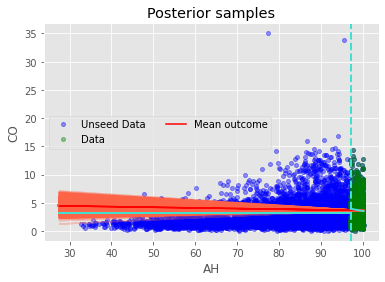

In [22]:
fig, ax = plt.subplots()

ax.plot(
    X_all[:, 2], X_all[:, 9], "o", ms=4, alpha=0.4, label="Unseed Data", color="blue",
)
ax.plot(
    X_train[:, 2], X_train[:, 9], "o", ms=4, alpha=0.4, label="Data", color="green",
)
for j in range(mu_pp.shape[0]):
    ax.plot(X_all[:, 2], mu_pp[j], alpha=0.3, color="tomato")
ax.plot(X_all[:, 2], mn_sol, color="red", label="Mean outcome")
xmin_v = df.AH.min()
xmid_v = xmid * scaler.scale_[2] + scaler.mean_[2]
xmax_v = df.AH.max()
ymin_v = -0.2 * scaler.scale_[9] + scaler.mean_[9]
ymid_v = -0.2 * scaler.scale_[9] + scaler.mean_[9]
ymid_v2 = -0.05 * xmid * scaler.scale_[9] + scaler.mean_[9]
ymax_v = -0.05 * AH_val.max() * scaler.scale_[9] + scaler.mean_[9]
plt.plot(
    [xmin_v, xmid_v],
    [ymin_v, ymid_v],
    linestyle="solid",
    color="turquoise",
    linewidth=2,
)
plt.plot(
    [xmid_v, xmax_v],
    [ymid_v2, ymax_v],
    linestyle="solid",
    color="turquoise",
    linewidth=2,
)
plt.axvline(
    xmid * scaler.scale_[2] + scaler.mean_[2],
    c="turquoise",
    linestyle="dashed",
    linewidth=2,
)
ax.set_xlabel("AH")
ax.set_ylabel("CO")
ax.set_title("Posterior samples")
ax.legend(ncol=2, fontsize=10)
# fig.savefig(
#     "CO_AH_regrAHrule01", dpi=300, bbox_inches="tight", facecolor="w",
# )

Take posterior samples and evaluate the posterior mean

In [23]:
X_all5_sc = (X_all[:, 5] - scaler.mean_[5]) / scaler.scale_[5]
mu_pp_inter = (
    trace_AHrule["intercept"][::100]
    + trace_AHrule["TIT_co"][::100] * X_all5_sc[:, None]
).T
mu_pp = mu_pp_inter * scaler.scale_[9] + scaler.mean_[9]

mn_sol_inter = mu_pp_inter = (
    trace_AHrule["intercept"][::100].mean()
    + trace_AHrule["TIT_co"][::100].mean() * X_all5_sc[:, None]
).T.reshape(-1)
mn_sol = mn_sol_inter * scaler.scale_[9] + scaler.mean_[9]

Plot the TIT-CO posterior

/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


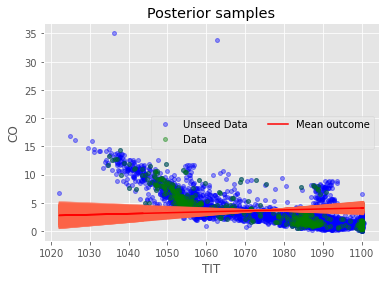

In [24]:
fig, ax = plt.subplots()

ax.plot(
    X_all[:, 5], X_all[:, 9], "o", ms=4, alpha=0.4, label="Unseed Data", color="blue",
)
ax.plot(
    X_train[:, 5], X_train[:, 9], "o", ms=4, alpha=0.4, label="Data", color="green",
)
for j in range(mu_pp.shape[0]):
    ax.plot(X_all[:, 5], mu_pp[j], alpha=0.3, color="tomato")
ax.plot(X_all[:, 5], mn_sol, color="red", label="Mean outcome")
ax.set_xlabel("TIT")
ax.set_ylabel("CO")
ax.set_title("Posterior samples")
ax.legend(ncol=2, fontsize=10)
# fig.savefig(
#     "CO_TIT_regrAHrule01", dpi=300, bbox_inches="tight", facecolor="w",
# )

Evaluate metrics

In [25]:
pred = (
    trace_AHrule["AT_co"].mean() * df["AT"].to_numpy()
    + trace_AHrule["AP_co"].mean() * df["AP"].to_numpy()
    + trace_AHrule["AH_co"].mean() * df["AH"].to_numpy()
    + trace_AHrule["AFDP_co"].mean() * df["AFDP"].to_numpy()
    + trace_AHrule["GTEP_co"].mean() * df["GTEP"].to_numpy()
    + trace_AHrule["TIT_co"].mean() * df["TIT"].to_numpy()
    + trace_AHrule["TAT_co"].mean() * df["TAT"].to_numpy()
    + trace_AHrule["TEY_co"].mean() * df["TEY"].to_numpy()
    + trace_AHrule["CDP_co"].mean() * df["CDP"].to_numpy()
    + trace_AHrule["intercept"].mean()
)

mse = mean_squared_error(df["CO"].to_numpy(), pred)
mae = mean_absolute_error(df["CO"].to_numpy(), pred)

with open("COmetrics.txt", "a") as text_file:
    print("Metrics with AH rules", file=text_file)
    print(f"mse: {mse}", file=text_file)
    print(f"mae: {mae}", file=text_file)

## Rule-based Bayesian multivariate linear regression (CDP-TAT intersection rules)

Define the rule

In [26]:
no_points = 10
x1low = min(CDP_val)
x1mid = -0.15
x1hi = max(CDP_val)

x2low = min(TAT_val)
x2mid = -0.55
x2hi = max(TAT_val)

rule_first_x1 = np.linspace(x1low, x1mid, no_points)
rule_second_x1 = np.linspace(x1mid, x1hi, no_points)

rule_first_x2 = np.linspace(x2low, x2mid, no_points)
rule_second_x2 = np.linspace(x2mid, x2hi, no_points)

ymid = -0.75

grid = np.array(np.meshgrid(rule_first_x2, rule_second_x1)).reshape(2, -1).T

Define the rule function

In [27]:
def logp_rule_nopm(
    CDP_co, TAT_co, b_lat,
):

    points_r1_x2 = grid[:, 0] * TAT_co + b_lat

    points_r2_x1 = grid[:, 1] * CDP_co + b_lat

    rule_log_lik = 0
    for i in range(no_points):
        rule_log_lik = rule_log_lik + pm.math.switch(
            pm.math.and_(
                pm.math.gt(points_r2_x1[i], ymid), pm.math.gt(points_r1_x2[i], ymid)
            ),
            pm.math.sqrt(pm.math.sqr(points_r2_x1[i] - ymid))
            + pm.math.sqrt(pm.math.sqr(points_r1_x2[i] - ymid)),
            0,
        )

    return pm.Exponential.dist(100).logp(rule_log_lik)

Run the model

In [28]:
with pm.Model() as model_combrule:
    # define priors
    AT_co = pm.Normal("AT_co", 0.0, 10.0)
    AP_co = pm.Normal("AP_co", 0.0, 10.0)
    AH_co = pm.Normal("AH_co", 0.0, 10.0)
    AFDP_co = pm.Normal("AFDP_co", 0.0, 10.0)
    GTEP_co = pm.Normal("GTEP_co", 0.0, 10.0)
    TIT_co = pm.Normal("TIT_co", 0.0, 10.0)
    TAT_co = pm.Normal("TAT_co", 0.0, 10.0)
    TEY_co = pm.Normal("TEY_co", 0.0, 10.0)
    CDP_co = pm.Normal("CDP_co", 0.0, 10.0)
    b = pm.Normal("intercept", 0, 20)
    s = pm.Exponential("error", 1)

    b_lat = pm.Normal("intercept_lat", 0, 20.0, testval=-10)

    res = (
        AT_co * AT_val
        + AP_co * AP_val
        + AH_co * AH_val
        + AFDP_co * AFDP_val
        + GTEP_co * GTEP_val
        + TIT_co * TIT_val
        + TAT_co * TAT_val
        + TEY_co * TEY_val
        + CDP_co * CDP_val
        + b
    )

    # predictions
    obs = pm.Normal("observation", res, s, observed=CO_val,)
    LL_rule = pm.Potential("LL_rule", logp_rule_nopm(CDP_co, TAT_co, b_lat))

with model_combrule:
    step = pm.Metropolis(scaling=0.01)
    trace_combrule = pm.sample(draws=100000, step=step, tune=30000, cores=1, chains=1)

<ipython-input-28-ff1f1ce87237>:36: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_combrule = pm.sample(draws=100000, step=step, tune=30000, cores=1, chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [intercept_lat]
>Metropolis: [error]
>Metropolis: [intercept]
>Metropolis: [CDP_co]
>Metropolis: [TEY_co]
>Metropolis: [TAT_co]
>Metropolis: [TIT_co]
>Metropolis: [GTEP_co]
>Metropolis: [AFDP_co]
>Metropolis: [AH_co]
>Metropolis: [AP_co]
>Metropolis: [AT_co]


Sampling 1 chain for 30_000 tune and 100_000 draw iterations (30_000 + 100_000 draws total) took 260 seconds.
/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/arviz/data/base.py:216: UserWarning: More chains (100000) than draws (12). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


Evaluate metrics

In [29]:
pred = (
    trace_combrule["AT_co"].mean() * df["AT"].to_numpy()
    + trace_combrule["AP_co"].mean() * df["AP"].to_numpy()
    + trace_combrule["AH_co"].mean() * df["AH"].to_numpy()
    + trace_combrule["AFDP_co"].mean() * df["AFDP"].to_numpy()
    + trace_combrule["GTEP_co"].mean() * df["GTEP"].to_numpy()
    + trace_combrule["TIT_co"].mean() * df["TIT"].to_numpy()
    + trace_combrule["TAT_co"].mean() * df["TAT"].to_numpy()
    + trace_combrule["TEY_co"].mean() * df["TEY"].to_numpy()
    + trace_combrule["CDP_co"].mean() * df["CDP"].to_numpy()
    + trace_combrule["intercept"].mean()
)

mse = mean_squared_error(df["CO"].to_numpy(), pred)
mae = mean_absolute_error(df["CO"].to_numpy(), pred)

rule_waic = az.waic(trace_combrule, model_combrule, scale="deviance")

with open("COmetrics.txt", "a") as text_file:
    print("Metrics with intersection rules", file=text_file)
    print(f"mse: {mse}", file=text_file)
    print(f"mae: {mae}", file=text_file)
    print(f"waic: {rule_waic.waic}", file=text_file)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/arviz/data/base.py:216: UserWarning: More chains (100000) than draws (12). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/usr/local/anaconda3/envs/daskk/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
